# Catnip

In [1]:
# Dependencies and configuration
import os
import importlib
from src.config import settings

os.makedirs(settings.panels_dir, exist_ok=True)
os.makedirs(settings.crops_dir, exist_ok=True)
os.makedirs(settings.izutsumi_dir, exist_ok=True)
os.makedirs(settings.output_dir, exist_ok=True)

seed_paths = [str(p) for p in sorted(settings.izutsumi_dir.glob("*.jpg"))] # Seeds

## Pre-processing

### Panel extraction

In [ ]:
from modules.coreMPE.src.adenzu_panel.image_processing import panel

_ = panel.extract_panels_for_images_in_folder_recursive(
    input_dir=str(settings.pages_dir),
    output_dir=str(settings.panels_dir),
    split_joint_panels=False,   # maps to --split-joint-panels
    fallback=True              # maps to --fallback
)

### Head crops

In [ ]:
# Extract head crops (YOLOv8_animeface)
from src.headExtraction import anime_extraction_recursive

valid_exts = {".jpg", ".jpeg", ".png"}
panel_paths = sorted(
    [p for p in settings.panels_dir.iterdir() if p.suffix.lower() in valid_exts]
)
num_crops = anime_extraction_recursive()

print(f"Extracted {num_crops} faces")

## Catnip core

### Model building

#### New model

In [ ]:
# Compute embeddings for dataset and save (including model weights)
from src.embeddingModel import compute_embeddings, build_model
IMG_SIZE = 128

# Build fresh model without loading weights (for new embedding computation)
embed_model = build_model(IMG_SIZE, settings.crops_dir, load_weights=False)
compute_embeddings(embed_model, settings.crops_dir, IMG_SIZE)

#### Previous model

In [2]:
# Build embedding model (loads saved weights if available)
from src.embeddingModel import build_model, load_embeddings
IMG_SIZE = 128

embed_model = build_model(IMG_SIZE, settings.crops_dir, load_weights=True)
embs, crop_paths = load_embeddings(settings.embed_path, settings.crop_path)

Loaded model weights from data/model.weights.h5
Loaded embeddings of shape (20654, 1024)


## Visualization

In [ ]:
import src.visualization
importlib.reload(src.visualization)

In [3]:
from src.visualization import izutsumi_query

crop, index, score, thre = izutsumi_query(settings.embed_path,
                                        settings.crop_path,
                                        IMG_SIZE, 
                                        embed_model, 
                                        seed_paths,
                                        similarity_threshold=0.8)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Found 641 crops above similarity threshold 0.8
Found 641 crops above similarity threshold 0.8


In [ ]:
from src.visualization import save_similar_results

save_similar_results(crop, index, settings.output_dir)

Showing top 40 results out of 641 matches


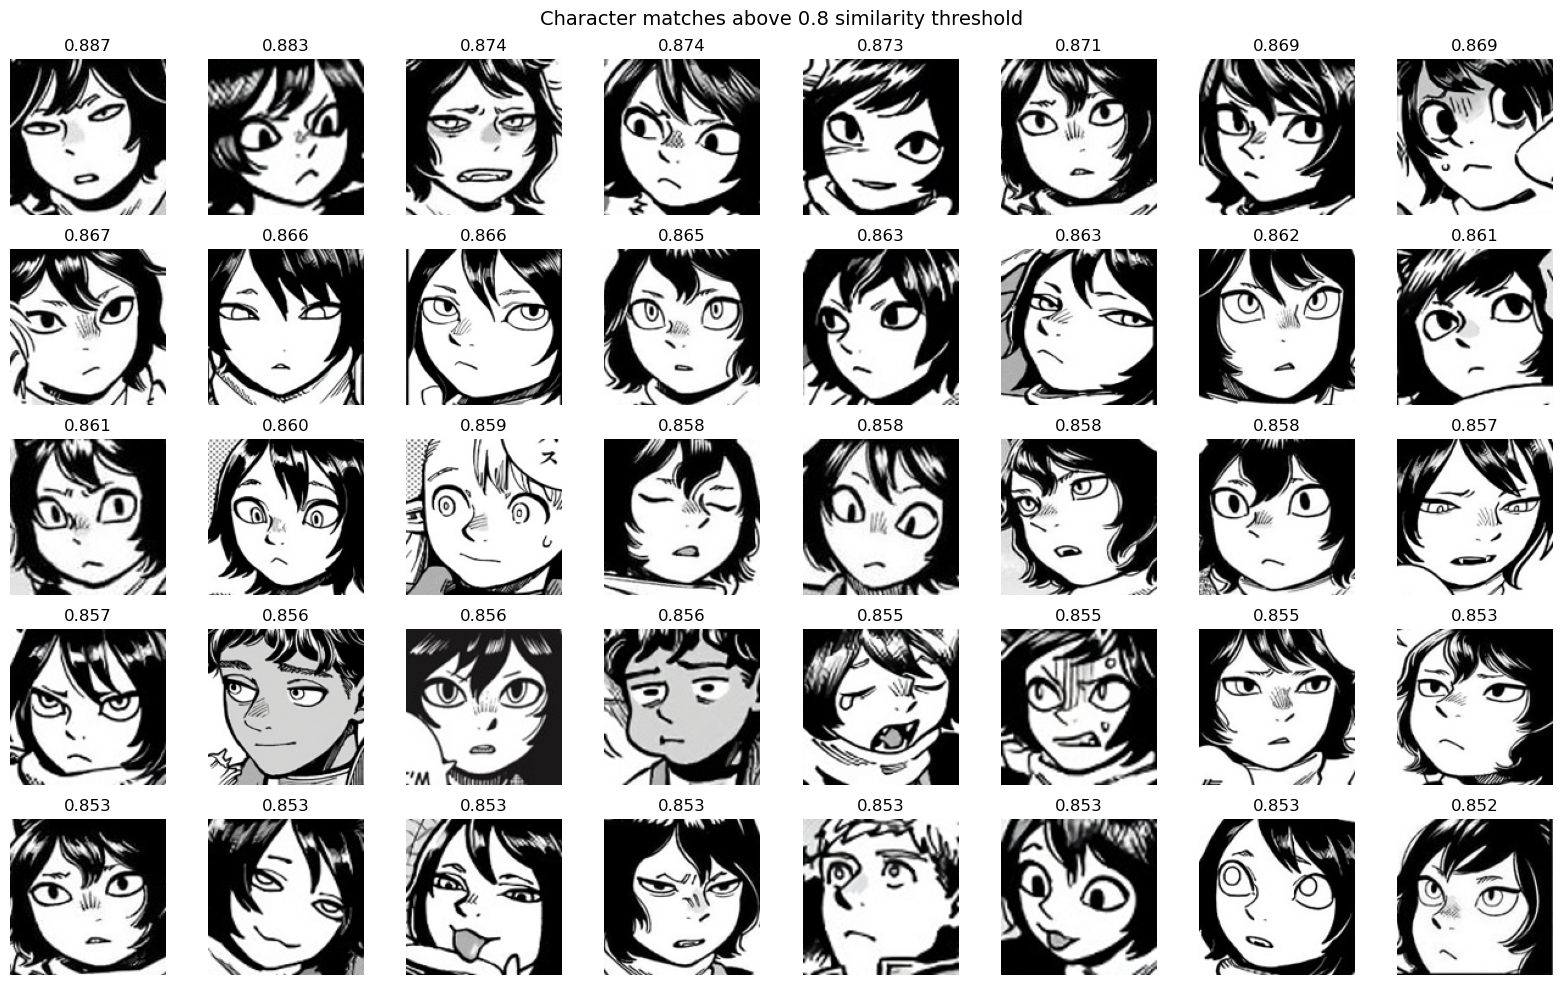

In [ ]:
from src.visualization import char_nearest_neighbor

# Find character matches above threshold
results = char_nearest_neighbor(crop, index, score, thre)